In [1]:
!kaggle datasets download vipoooool/new-plant-diseases-dataset

/bin/bash: line 1: kaggle: command not found


In [1]:
import os
import glob
import keras
import tensorflow as tf
import numpy as np
from binary_train_and_eval import gen_dataset

In [2]:
keras.config.enable_unsafe_deserialization()

In [3]:
MODEL_DIR = "out"
model_files = [file for file in glob.glob(os.path.join(MODEL_DIR, "*_rgb.keras"))]
#model_files = [max(glob.glob(os.path.join("checkpoints", model_dir, "*")), key=os.path.getctime) for model_dir in os.listdir("checkpoints") if model_dir.endswith("_rgb")]
print(model_files)
TEST_DATA_PATH = os.path.join("_data", "combined", "test")
INPUT_SHAPE = (224, 224, 3)

['out/bestInceptionV3_rgb.keras', 'out/bestVisionTransformer_rgb.keras', 'out/bestAlexNet_rgb.keras', 'out/bestLeNet_rgb.keras', 'out/bestResNet152V2_rgb.keras', 'out/bestMobileNetV3Large_rgb.keras', 'out/bestVGG19_rgb.keras', 'out/bestConvNeXtLarge_rgb.keras']


In [4]:
models = {file.split("/")[-1].replace('best', '').replace('_rgb.keras', ''): keras.saving.load_model(file) for file in model_files}

2024-11-16 11:54:59.696958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28824 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [5]:
print(models.keys())

dict_keys(['InceptionV3', 'VisionTransformer', 'AlexNet', 'LeNet', 'ResNet152V2', 'MobileNetV3Large', 'VGG19', 'ConvNeXtLarge'])


In [6]:
test_dataset = gen_dataset(TEST_DATA_PATH, batch_size=8, lab=False, input_shape=INPUT_SHAPE, aug=False, deterministic=True)

Found 9202 files belonging to 2 classes.


In [7]:
test_dataset = keras.utils.image_dataset_from_directory(TEST_DATA_PATH, 
                                                        batch_size=8, 
                                                        image_size=INPUT_SHAPE[:2], 
                                                        crop_to_aspect_ratio=True, 
                                                        labels="inferred", 
                                                        label_mode="binary",
                                                        shuffle=False)
test_dataset = test_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=2)))

Found 9202 files belonging to 2 classes.


In [8]:
y_trues = tf.concat(list(test_dataset.map(lambda x,y: y)), axis=0)

2024-11-16 11:56:36.417189: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
def reduce_y(y):
    return np.argmax(y, axis=1)

In [11]:
total = len(y_trues)
unique, counts = np.unique(reduce_y(y_trues), return_counts=True)
label_weights = counts / total

In [12]:
label_weights

array([0.68083025, 0.31916975])

In [13]:
preds = dict()
results = dict()

In [15]:
metrics=[
    keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(label_weights=label_weights),
    tf.keras.metrics.F1Score(),
]

In [ ]:
for name, model in models.items():
    print(f"Evaluating {name}")
    result = {}
    
    y_preds = model.predict(test_dataset.map(lambda x,y: x))
    
    for metric in metrics:
        result[metric.name] = metric(y_trues, y_preds).numpy()
        
    print(result)
    
    results[name] = result
    preds[name] = {
        'y_true': y_trues,
        'y_pred': y_preds
    }

Evaluating InceptionV3


I0000 00:00:1731754701.285503 2607612 service.cc:146] XLA service 0x14ce380033d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731754701.285541 2607612 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-16 11:58:21.379999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 11:58:22.129802: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  11/1151 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step

I0000 00:00:1731754707.603225 2607612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1151/1151 ━━━━━━━━━━━━━━━━━━━━ 73s 57ms/step


2024-11-16 11:59:32.685842: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_multiply_fusion', 4 bytes spill stores, 4 bytes spill loads



(9202, 2) tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(9202, 2), dtype=float32)
(9202, 2) [[9.99974728e-01 2.52837763e-05]
 [9.92849350e-01 7.15066586e-03]
 [4.64851141e-01 5.35148859e-01]
 ...
 [2.41155612e-06 9.99997616e-01]
 [1.35677010e-02 9.86432254e-01]
 [1.06492974e-01 8.93507063e-01]]
{'binary_accuracy': 0.80797654, 'recall_1': 0.80797654, 'auc_1': 0.89413947, 'f1_score': array([0.8376068 , 0.76512027], dtype=float32)}
Evaluating VisionTransformer


2024-11-16 11:59:40.584092: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 200 bytes spill stores, 200 bytes spill loads

2024-11-16 11:59:49.275145: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 204 bytes spill stores, 204 bytes spill loads



1149/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

2024-11-16 12:01:03.522428: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 200 bytes spill stores, 200 bytes spill loads

2024-11-16 12:01:13.639850: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 204 bytes spill stores, 204 bytes spill loads



1151/1151 ━━━━━━━━━━━━━━━━━━━━ 107s 70ms/step
(9202, 2) tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(9202, 2), dtype=float32)
(9202, 2) [[0.3272762  0.68122816]
 [0.52546465 0.48911723]
 [0.33559784 0.6723474 ]
 ...
 [0.30072713 0.7084287 ]
 [0.35002732 0.6589333 ]
 [0.36687818 0.6422053 ]]
{'binary_accuracy': 0.64559335, 'recall_1': 0.65105414, 'auc_1': 0.7720853, 'f1_score': array([0.6510706 , 0.64044565], dtype=float32)}
Evaluating AlexNet


2024-11-16 12:02:01.952670: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_210', 88 bytes spill stores, 88 bytes spill loads



1149/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

2024-11-16 12:03:04.240977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_210', 72 bytes spill stores, 72 bytes spill loads



1151/1151 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step
(9202, 2) tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(9202, 2), dtype=float32)
(9202, 2) [[9.7748488e-01 2.2515098e-02]
 [9.9522519e-01 4.7748121e-03]
 [6.7105407e-01 3.2894596e-01]
 ...
 [5.9005490e-04 9.9940991e-01]
 [8.5732769e-03 9.9142671e-01]
 [6.1495144e-02 9.3850487e-01]]
{'binary_accuracy': 0.7297146, 'recall_1': 0.73335505, 'auc_1': 0.8558222, 'f1_score': array([0.75545204, 0.6983292 ], dtype=float32)}
Evaluating LeNet
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step
(9202, 2) tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(9202, 2), dtype=float32)
(9202, 2) [[0.8172138  0.18278626]
 [0.8172138  0.18278626]
 [0.8172138  0.18278626]
 ...
 [0.8172138  0.18278626]
 [0.8172138  0.18278626]
 [0.8172138  0.18278626]]
{'binary_accuracy': 0.7174935, 'recall_1': 0.72022384, 'auc_1': 0.8214347, 'f1_score': array([0.7738467, 0.6241682], dtype=float32)}
Evaluating ResNet152V2
1151/1

2024-11-16 12:07:18.707778: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads



1149/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

2024-11-16 12:08:21.811323: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads



1151/1151 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step
(9202, 2) tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(9202, 2), dtype=float32)
(9202, 2) [[0.92526656 0.07473344]
 [0.9985246  0.00147543]
 [0.9945069  0.00549307]
 ...
 [0.01890274 0.9810972 ]
 [0.11960419 0.8803958 ]
 [0.15899661 0.84100336]]
{'binary_accuracy': 0.7462896, 'recall_1': 0.7478498, 'auc_1': 0.84228855, 'f1_score': array([0.80948263, 0.6206816 ], dtype=float32)}
Evaluating ConvNeXtLarge


2024-11-16 12:08:47.396265: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2024-11-16 12:08:58.242738: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 52 bytes spill stores, 52 bytes spill loads



In [12]:
results

{'InceptionV3': {'binary_accuracy': 0.8080852,
  'recall': 0.8080852,
  'auc': 0.8877817,
  'f1_score': array([0.8377136 , 0.76522195], dtype=float32)},
 'VisionTransformer': {'binary_accuracy': 0.65034777,
  'recall': 0.66208434,
  'auc': 0.7618072,
  'f1_score': array([0.6570027, 0.6433163], dtype=float32)},
 'AlexNet': {'binary_accuracy': 0.73288417,
  'recall': 0.74070853,
  'auc': 0.8499596,
  'f1_score': array([0.7588056, 0.7006291], dtype=float32)},
 'LeNet': {'binary_accuracy': 0.7198707,
  'recall': 0.72573894,
  'auc': 0.8224266,
  'f1_score': array([0.7760402, 0.6259973], dtype=float32)},
 'ResNet152V2': {'binary_accuracy': 0.74292547,
  'recall': 0.7476201,
  'auc': 0.844108,
  'f1_score': array([0.79950505, 0.64177334], dtype=float32)},
 'MobileNetV3Large': {'binary_accuracy': 0.73257625,
  'recall': 0.73648846,
  'auc': 0.82708853,
  'f1_score': array([0.80170804, 0.5893542 ], dtype=float32)},
 'VGG19': {'binary_accuracy': 0.7476325,
  'recall': 0.7509858,
  'auc': 0.8447

In [13]:
#results = {name: {key: value.numpy() for key, value in data.items() } for name, data in results.items()}

In [14]:
import pickle
with open(os.path.join("out", "result.pkl"), "wb+") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
results_data = [{**{'name': name}, **data, 'f1_score': data['f1_score'][0]} for name, data in results.items()]

In [16]:
import pandas as pd
df = pd.DataFrame(results_data)

In [17]:
df

,name,binary_accuracy,recall,auc,f1_score
0,InceptionV3,0.808085,0.808085,0.887782,0.837714
1,VisionTransformer,0.650348,0.662084,0.761807,0.657003
2,AlexNet,0.732884,0.740709,0.849960,0.758806
3,LeNet,0.719871,0.725739,0.822427,0.776040
4,ResNet152V2,0.742925,0.747620,0.844108,0.799505
5,MobileNetV3Large,0.732576,0.736488,0.827089,0.801708
6,VGG19,0.747633,0.750986,0.844800,0.810619
7,ConvNeXtLarge,0.737122,0.740057,0.832275,0.798392


In [18]:
df.set_index('name')
df.loc["Sum"] = df.sum(numeric_only=True)

df.to_latex(float_format="%.4f")

'\\begin{tabular}{llrrrr}\n\\toprule\n & name & binary_accuracy & recall & auc & f1_score \\\\\n\\midrule\n0 & InceptionV3 & 0.8081 & 0.8081 & 0.8878 & 0.8377 \\\\\n1 & VisionTransformer & 0.6503 & 0.6621 & 0.7618 & 0.6570 \\\\\n2 & AlexNet & 0.7329 & 0.7407 & 0.8500 & 0.7588 \\\\\n3 & LeNet & 0.7199 & 0.7257 & 0.8224 & 0.7760 \\\\\n4 & ResNet152V2 & 0.7429 & 0.7476 & 0.8441 & 0.7995 \\\\\n5 & MobileNetV3Large & 0.7326 & 0.7365 & 0.8271 & 0.8017 \\\\\n6 & VGG19 & 0.7476 & 0.7510 & 0.8448 & 0.8106 \\\\\n7 & ConvNeXtLarge & 0.7371 & 0.7401 & 0.8323 & 0.7984 \\\\\nSum & NaN & 5.8714 & 5.9118 & 6.6702 & 6.2398 \\\\\n\\bottomrule\n\\end{tabular}\n'

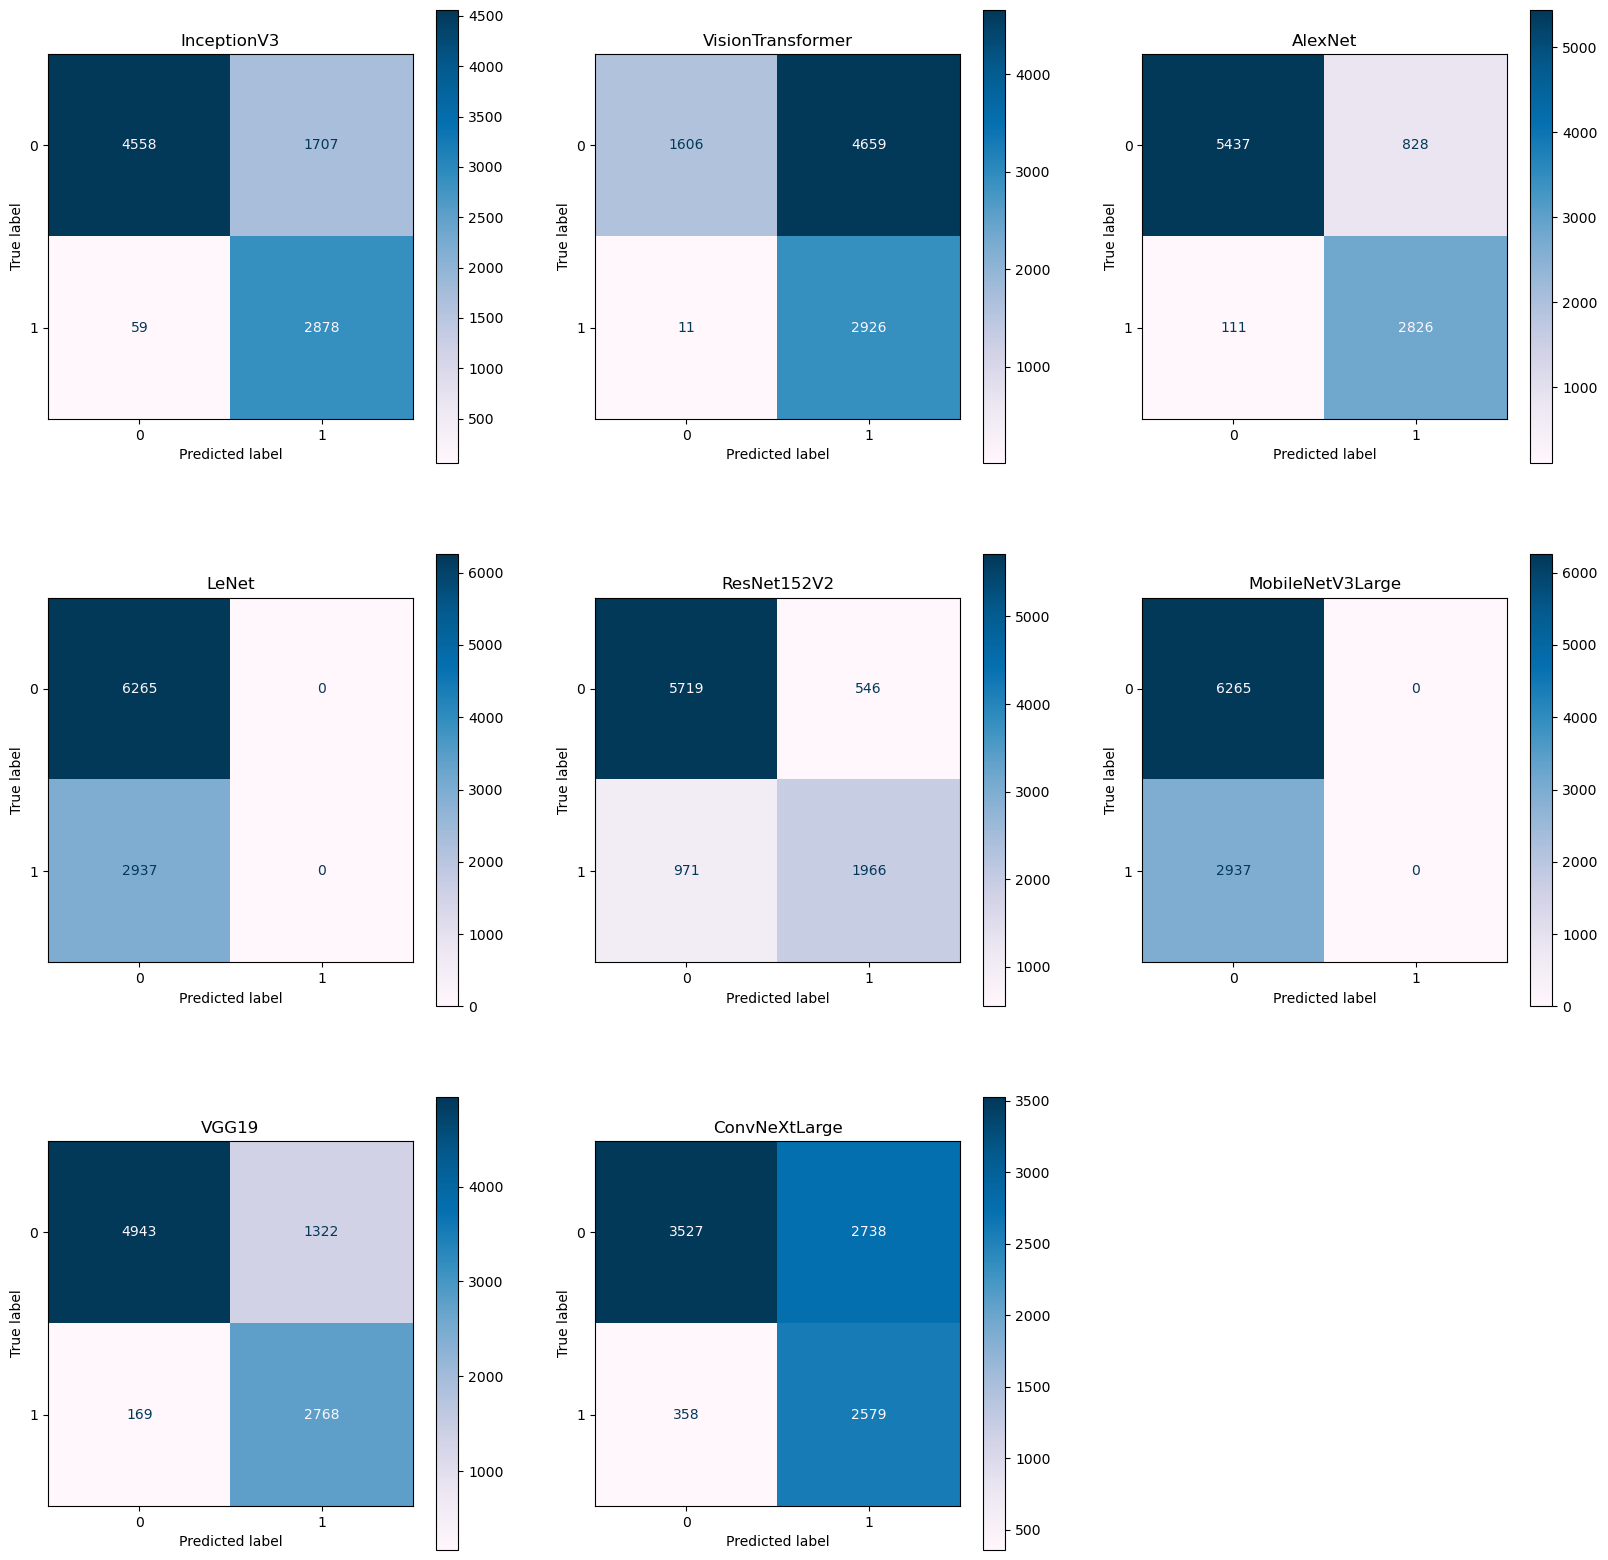

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']),
                                                   cmap="PuBu", ax=ax)
    disp.ax_.set_title(name)
plt.show()

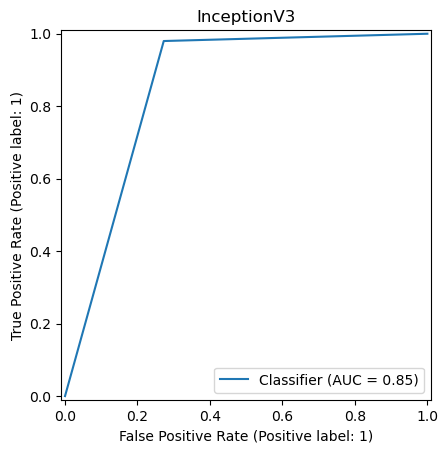

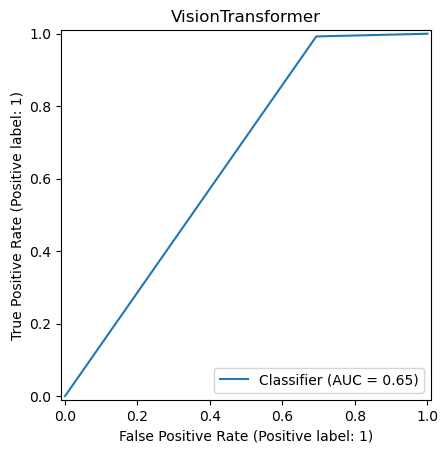

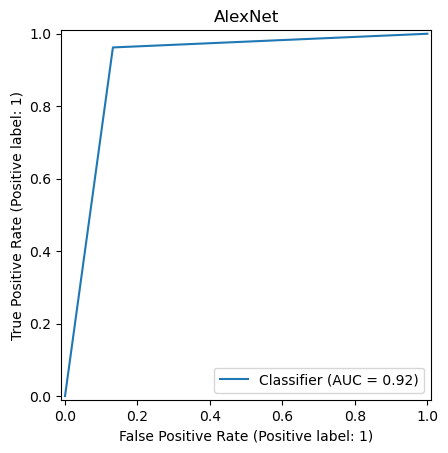

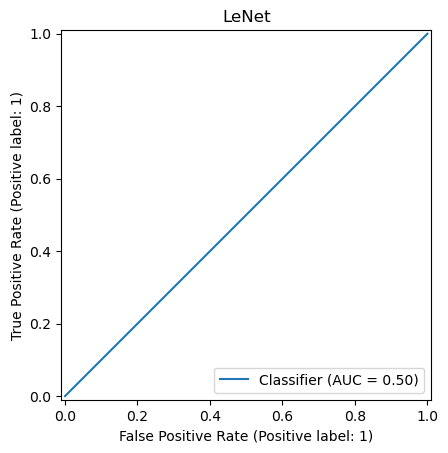

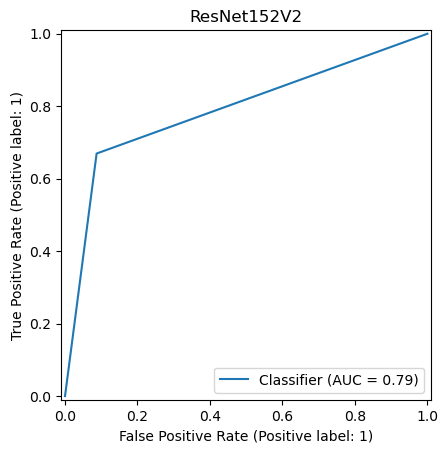

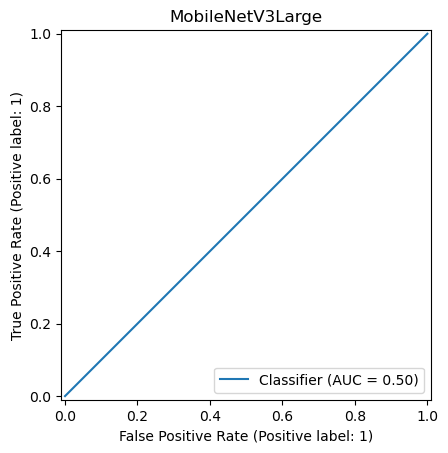

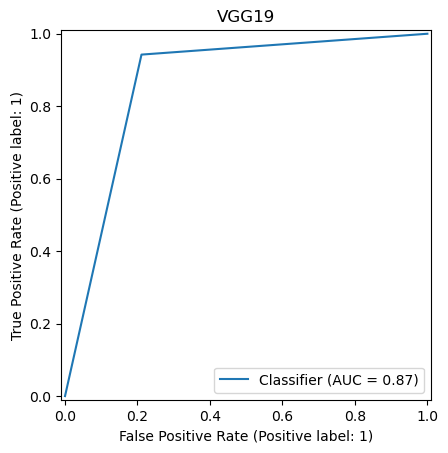

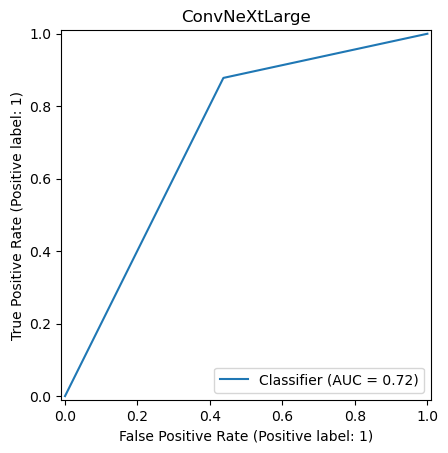

In [65]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = RocCurveDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()

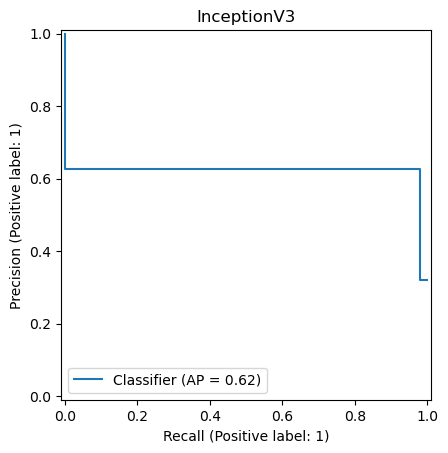

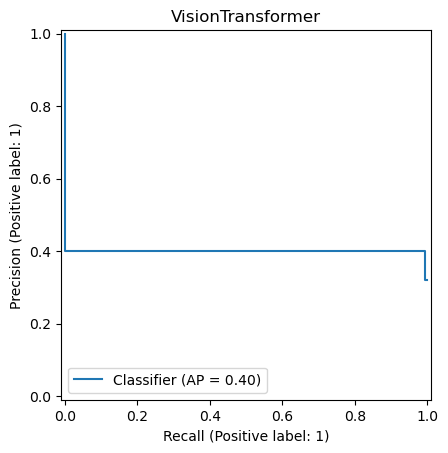

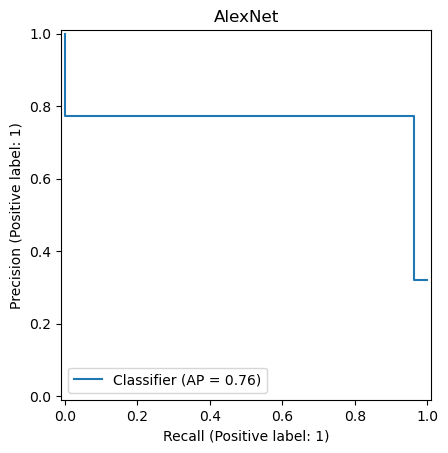

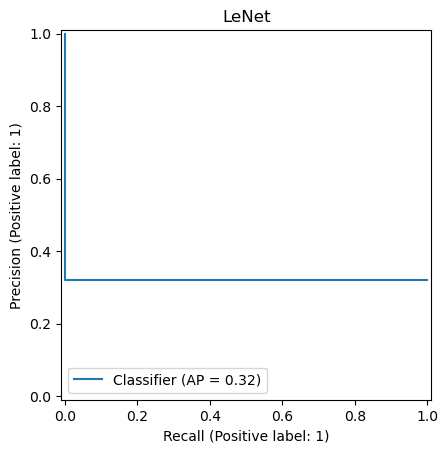

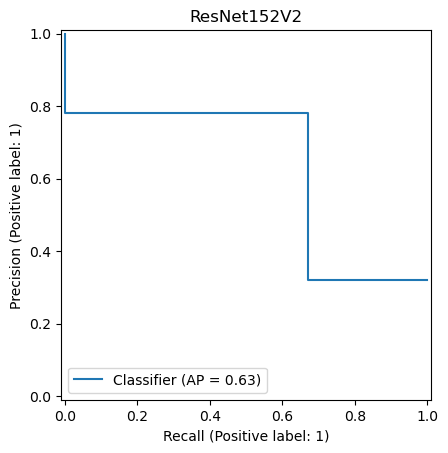

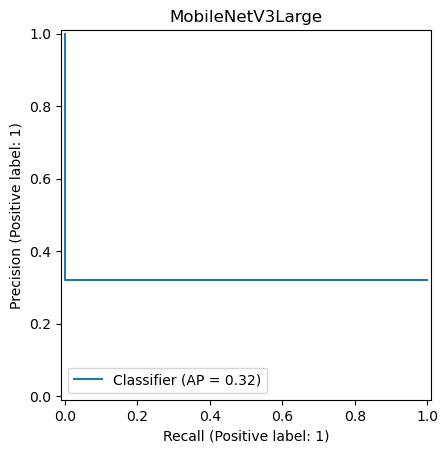

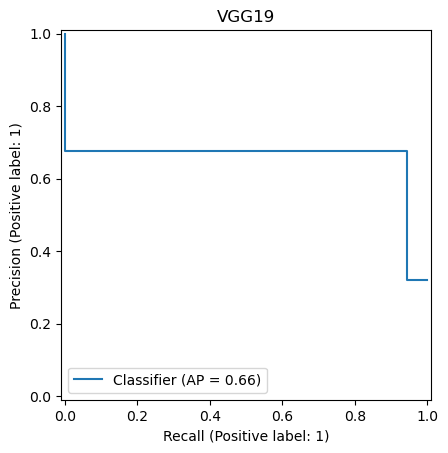

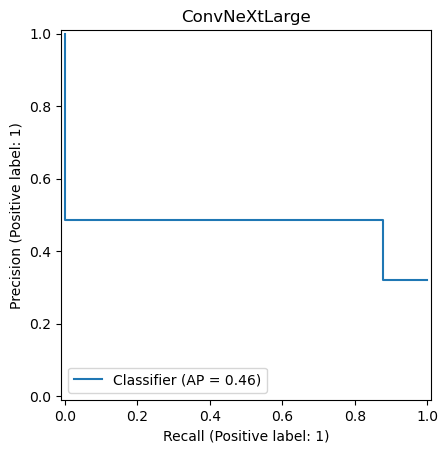

In [67]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = PrecisionRecallDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()